In [1]:

from pymongo import MongoClient
from pytz import timezone
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from nltk import PorterStemmer
import re
from scipy.sparse import hstack
from scipy.sparse import vstack
from scipy.sparse import csr_matrix
from sklearn import svm
from sklearn.utils import shuffle

from random import randint
from sklearn.cross_validation import StratifiedShuffleSplit
from copy import copy
import pandas as pd
from Levenshtein import *
%matplotlib inline



In [2]:
def load_stopwords(file_location="SmartStoplist"):
    f = open(file_location)
    stopwords = [line.strip() for line in f]
    return stopwords + ["http","https", "don", "thi","http ", "co","dont","im"]

stopwords = load_stopwords()
stemmer = PorterStemmer()
stopSet = set(stopwords)

def preprocessor(text):
    stemmer = PorterStemmer()
    words = []
    global stopSet
    
    for word in text.lower().split():
        word = re.sub('[!@#$?\'\"]|&amp', '',word)
        stemmedWord = stemmer.stem_word(word)
        condition_Word = word not in stopSet  and "http" not in word
        condition_StemmedWord = stemmedWord not in stopSet
        
        if  condition_Word and  condition_StemmedWord:
            words.append(stemmedWord)
    return " ".join(words)

In [3]:
def emptyHourTable():
    return np.zeros(24,dtype=float)


def getEmotion(tweet):
    emotion = tweet["groups"][0]["name"]
    return emotion

def getLocalTime(time, zone):
    zoneTable = {"International Date Line West":"Pacific/Midway","Midway Island":"Pacific/Midway","American Samoa":"Pacific/Pago_Pago","Hawaii":"Pacific/Honolulu","Alaska":"America/Juneau","Pacific Time (US & Canada)":"America/Los_Angeles","Tijuana":"America/Tijuana","Mountain Time (US & Canada)":"America/Denver","Arizona":"America/Phoenix","Chihuahua":"America/Chihuahua","Mazatlan":"America/Mazatlan","Central Time (US & Canada)":"America/Chicago","Saskatchewan":"America/Regina","Guadalajara":"America/Mexico_City","Mexico City":"America/Mexico_City","Monterrey":"America/Monterrey","Central America":"America/Guatemala","Eastern Time (US & Canada)":"America/New_York","Indiana (East)":"America/Indiana/Indianapolis","Bogota":"America/Bogota","Lima":"America/Lima","Quito":"America/Lima","Atlantic Time (Canada)":"America/Halifax","Caracas":"America/Caracas","La Paz":"America/La_Paz","Santiago":"America/Santiago","Newfoundland":"America/St_Johns","Brasilia":"America/Sao_Paulo","Buenos Aires":"America/Argentina/Buenos_Aires","Montevideo":"America/Montevideo","Georgetown":"America/Guyana","Greenland":"America/Godthab","Mid-Atlantic":"Atlantic/South_Georgia","Azores":"Atlantic/Azores","Cape Verde Is.":"Atlantic/Cape_Verde","Dublin":"Europe/Dublin","Edinburgh":"Europe/London","Lisbon":"Europe/Lisbon","London":"Europe/London","Casablanca":"Africa/Casablanca","Monrovia":"Africa/Monrovia","UTC":"Etc/UTC","Belgrade":"Europe/Belgrade","Bratislava":"Europe/Bratislava","Budapest":"Europe/Budapest","Ljubljana":"Europe/Ljubljana","Prague":"Europe/Prague","Sarajevo":"Europe/Sarajevo","Skopje":"Europe/Skopje","Warsaw":"Europe/Warsaw","Zagreb":"Europe/Zagreb","Brussels":"Europe/Brussels","Copenhagen":"Europe/Copenhagen","Madrid":"Europe/Madrid","Paris":"Europe/Paris","Amsterdam":"Europe/Amsterdam","Berlin":"Europe/Berlin","Bern":"Europe/Berlin","Rome":"Europe/Rome","Stockholm":"Europe/Stockholm","Vienna":"Europe/Vienna","West Central Africa":"Africa/Algiers","Bucharest":"Europe/Bucharest","Cairo":"Africa/Cairo","Helsinki":"Europe/Helsinki","Kyiv":"Europe/Kiev","Riga":"Europe/Riga","Sofia":"Europe/Sofia","Tallinn":"Europe/Tallinn","Vilnius":"Europe/Vilnius","Athens":"Europe/Athens","Istanbul":"Europe/Istanbul","Minsk":"Europe/Minsk","Jerusalem":"Asia/Jerusalem","Harare":"Africa/Harare","Pretoria":"Africa/Johannesburg","Kaliningrad":"Europe/Kaliningrad","Moscow":"Europe/Moscow","St. Petersburg":"Europe/Moscow","Volgograd":"Europe/Volgograd","Samara":"Europe/Samara","Kuwait":"Asia/Kuwait","Riyadh":"Asia/Riyadh","Nairobi":"Africa/Nairobi","Baghdad":"Asia/Baghdad","Tehran":"Asia/Tehran","Abu Dhabi":"Asia/Muscat","Muscat":"Asia/Muscat","Baku":"Asia/Baku","Tbilisi":"Asia/Tbilisi","Yerevan":"Asia/Yerevan","Kabul":"Asia/Kabul","Ekaterinburg":"Asia/Yekaterinburg","Islamabad":"Asia/Karachi","Karachi":"Asia/Karachi","Tashkent":"Asia/Tashkent","Chennai":"Asia/Kolkata","Kolkata":"Asia/Kolkata","Mumbai":"Asia/Kolkata","New Delhi":"Asia/Kolkata","Kathmandu":"Asia/Kathmandu","Astana":"Asia/Dhaka","Dhaka":"Asia/Dhaka","Sri Jayawardenepura":"Asia/Colombo","Almaty":"Asia/Almaty","Novosibirsk":"Asia/Novosibirsk","Rangoon":"Asia/Rangoon","Bangkok":"Asia/Bangkok","Hanoi":"Asia/Bangkok","Jakarta":"Asia/Jakarta","Krasnoyarsk":"Asia/Krasnoyarsk","Beijing":"Asia/Shanghai","Chongqing":"Asia/Chongqing","Hong Kong":"Asia/Hong_Kong","Urumqi":"Asia/Urumqi","Kuala Lumpur":"Asia/Kuala_Lumpur","Singapore":"Asia/Singapore","Taipei":"Asia/Taipei","Perth":"Australia/Perth","Irkutsk":"Asia/Irkutsk","Ulaanbaatar":"Asia/Ulaanbaatar","Seoul":"Asia/Seoul","Osaka":"Asia/Tokyo","Sapporo":"Asia/Tokyo","Tokyo":"Asia/Tokyo","Yakutsk":"Asia/Yakutsk","Darwin":"Australia/Darwin","Adelaide":"Australia/Adelaide","Canberra":"Australia/Melbourne","Melbourne":"Australia/Melbourne","Sydney":"Australia/Sydney","Brisbane":"Australia/Brisbane","Hobart":"Australia/Hobart","Vladivostok":"Asia/Vladivostok","Guam":"Pacific/Guam","Port Moresby":"Pacific/Port_Moresby","Magadan":"Asia/Magadan","Srednekolymsk":"Asia/Srednekolymsk","Solomon Is.":"Pacific/Guadalcanal","New Caledonia":"Pacific/Noumea","Fiji":"Pacific/Fiji","Kamchatka":"Asia/Kamchatka","Marshall Is.":"Pacific/Majuro","Auckland":"Pacific/Auckland","Wellington":"Pacific/Auckland","Nuku'alofa":"Pacific/Tongatapu","Tokelau Is.":"Pacific/Fakaofo","Chatham Is.":"Pacific/Chatham","Samoa":"Pacific/Apia"}
    offset = timezone(zoneTable[zone]).utcoffset(datetime.now())
    return time + offset

def getTweetHour(tweet):
    zone = tweet["user"]["time_zone"]
    return getLocalTime(tweet["created_at"], zone).hour



def getTweetSentimentHour(tweet):
    zone = tweet["user"]["time_zone"]
    return getLocalTime(tweet["created_at"], zone).hour








def getUserEmotionFrequency(collectionName, timeZone=True, regularization=True, percentage = False):

    client = MongoClient('localhost', 27017)
    collection = client['idea'][collectionName]
    userFrequency = {}

    for tweet in collection.find():
        zone = tweet["user"]["time_zone"]
        emotion =  tweet["emotion"]["groups"][0]["name"]
        if zone is not None:
            userID = tweet["user"]["id"]
            hour = getTweetHour(tweet)
            
            if userID not in userFrequency:
                userFrequency[userID] = {}
            if emotion not in userFrequency[userID]:
                    userFrequency[userID][emotion] = emptyHourTable()
                    
            userFrequency[userID][emotion][hour] += 1
    
   
    if regularization:
        for userID in userFrequency:
            for emotion in userFrequency[userID]:
                total = sum(userFrequency[userID][emotion])
                if percentage:
                    total /= 100
                for i in range(24):
                    userFrequency[userID][emotion][i] /=  total
            
    return userFrequency

 


def getUserFrequency(collectionName, timeZone=True, regularization=True, percentage = False):

    client = MongoClient('localhost', 27017)
    collection = client['idea'][collectionName]
    userFrequency = {}

    for tweet in collection.find():
        zone = tweet["user"]["time_zone"]
        if zone is not None:
            userID = tweet["user"]["id"]
            hour = getTweetHour(tweet)
            
            if userID not in userFrequency:
                userFrequency[userID] = emptyHourTable()
            userFrequency[userID][hour] += 1
    
    if regularization:
        for userID in userFrequency:
            total = sum(userFrequency[userID])
            if percentage:
                total /= 100
            for i in range(24):
                userFrequency[userID][i] /=  total
            
    return userFrequency


def frequencyPlot(userFrequency):
   
    X = []
    Y = []
    for hourTable in userFrequency.values():
        for i in range(24):
            if hourTable[i] < 0.3:
                X.append(i)
                Y.append(hourTable[i])
    X = np.array(X)
    Y = np.array(Y)
    fig, ax = plt.subplots()
    fit = np.polyfit(X, Y, deg=1)
    ax.plot(X, fit[0] * X + fit[1], color='red')
    ax.scatter(X, Y)

    fig.show()

    
    

 

def averagePlot(userFrequency, title):
    
    X = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
    Y = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    for hourTable in userFrequency.values():
        for i in range(24): 
            Y[i] += hourTable[i]
    
    X = np.array(X)
    Y = np.array(Y)
    Y /= len(userFrequency)
    fig, ax = plt.subplots()
    fit = np.polyfit(X, Y, deg=3)
    ax.plot(X, fit[0] * X**3+ + fit[1]*X**2+fit[2]*X+fit[3], color='red')
    ax.scatter(X, Y)
    ax.set_xlabel("Hour",  fontsize=14)
    ax.set_ylabel("Probablity to Post",  fontsize=14)
    fig.suptitle("{} {} people".format(len(userFrequency), title),  fontsize=18)
    
    fig.show()   

  

def personalPlot(userHour):  
        
    X = []
    Y = []

    for i in range(24):
        if userHour[i] > 0:
            X.append(i)
            Y.append(userHour[i])
            
    X = np.array(X)
    Y = np.array(Y)
    fig, ax = plt.subplots()
   
    fit = np.polyfit(X, Y, deg=2)
    ax.plot(X, fit[0] * X**2+ + fit[1]*X+fit[2], color='red')
    ax.scatter(X, Y)
    plt.axis((0,24,0,0.2))
    fig.show()
  
    
    
    
    
def getUsersData(collectionName, time= True):
    
    
    client = MongoClient('localhost', 27017)
    collection = client['idea'][collectionName]
    usersData = {}
    
    if time:

        for tweet in collection.find():
            zone = tweet["user"]["time_zone"]
            if zone is not None:
                userID = tweet["user"]["id"]
                hour = getTweetHour(tweet)
                text = tweet["text"]
                emotion = tweet["emotion"]["groups"][0]["name"]

                if userID not in usersData:
                    usersData[userID] = {"emotions":{}, "texts": []}
                if emotion not in usersData[userID]["emotions"]:
                    usersData[userID]["emotions"][emotion] = emptyHourTable()
                usersData[userID]["emotions"][emotion][hour] += 1
                usersData[userID]["texts"].append(text)

        for userID, data in usersData.items():
            total = len(data["texts"])
            for emotion in data["emotions"]:
                usersData[userID]["emotions"][emotion] /= total
                
    else:
         for tweet in collection.find():
            userID = tweet["user"]["id"]
            text = tweet["text"]

            if userID not in usersData:
                usersData[userID] = {"emotions":{}, "texts": []}
            
            usersData[userID]["texts"].append(text)
            
    return usersData










In [4]:

 





def getTFIDF(usersDataList):
    textsList = []
    for usersData in usersDataList:
        texts = ""
        for data in usersData.values():
            for text in data["texts"]:
                texts += preprocessor(text) + "\n"
        textsList.append(texts)
 
    tfidf = TfidfVectorizer(stop_words="english",ngram_range = (1,2))
    tfidf.fit(textsList)
    return tfidf




 
        

    
def getEmotionFeature(usersDataList):
    
    emotions = ['surprise', 'fear', 'sadness', 'disgust', 'trust', 'anticipation', 'anger','joy']
    featuresList = []

    
    for usersData in usersDataList:
        features = []
        for data in usersData.values():
            feature = np.array([])
            emotionCompositions = np.zeros(len(emotions),dtype=float)
            for i, emotion in enumerate(emotions):
                feature = np.concatenate((feature, (data["emotions"].get(emotion, emptyHourTable()))))
                emotionCompositions[i] = np.sum(data["emotions"].get(emotion, emptyHourTable()))
            feature = np.concatenate((feature,emotionCompositions))
            features.append(feature)
            
        featuresList.append(np.array(features))
        
    return featuresList



def getTextFeature(usersDataList, text_model):
    if text_model == "tfidf":
       model = TfidfVectorizer(stop_words="english",ngram_range = (1,2))
    
    getText = lambda data : "\n".join(data["texts"])
    usersTextsList = []
    totalTexts = []
    for usersData in usersDataList:
        usersTexts = []
        for data in usersData.values():
            text = getText(data)
            totalTexts.append(text)
            usersTexts.append(text)
        usersTextsList.append(usersTexts)
    model.fit(totalTexts)
    
    featuresList = []
    for usersTexts in usersTextsList:
        featuresList.append(model.transform(usersTexts))
        
    return featuresList, model

def featureCombination(emotion_features, text_features):
    featuresList = []
    for i in range(len(emotion_features)):
        new_features = csr_matrix(hstack((emotion_features[i], text_features[i])))
        
        featuresList.append(new_features)
    return featuresList
    

    
def featureExtraction(usersDataList, emotion_extraction=True, text_extraction=True, text_model="tfidf"):
    
    featuresList = []
 
    
    if emotion_extraction:
        emotion_features = getEmotionFeature(usersDataList)
        
        if not text_extraction:
            featuresList = emotion_features
        
        
    if text_extraction:
        
        text_features, model = getTextFeature(usersDataList, text_model)
        
        
        if emotion_extraction:
            featuresList = featureCombination(emotion_features, text_features)
        else:
            featuresList = text_features
        
    Ylist = []
    for label, usersData in enumerate(usersDataList):
        Y = np.zeros(len(usersData),dtype=int)
        Y[:] = label
        Ylist.append(Y)
        
    if text_extraction:
        return list(zip(featuresList, Ylist)), model 
    else:
        return list(zip(featuresList, Ylist)) 
    
    
  

In [5]:
def trainTestGenerator(featuresList, randomState, verbose=True):
    x, y = featuresList[0]
    X_TRAIN,X_TEST, Y_TRAIN,Y_TEST = train_test_split(x,y, random_state=randomState)
    
    normal_train = X_TRAIN.shape[0]
    normal_test = X_TEST.shape[0]
    
    for x, y in featuresList[1:]:
        x_train,x_test, y_train, y_test = train_test_split(x,y, random_state=randomState)
        
        X_TRAIN = vstack([X_TRAIN, x_train])    
        X_TEST = vstack([X_TEST, x_test]) 
        Y_TRAIN = np.concatenate((Y_TRAIN, y_train))   
        Y_TEST = np.concatenate((Y_TEST, y_test))
        
        BPD_train = x_train.shape[0]
        BPD_test = x_test.shape[0]
        
 
    
    return X_TRAIN, X_TEST, Y_TRAIN, Y_TEST

In [6]:
def XYGenerator(featuresList,verbose=True):
    X, Y = featuresList[0]
    

    
    for x, y in featuresList[1:]:
        try:
            
            X = np.concatenate((X, x))
        except:
            X = vstack([X, x])
            
        Y = np.concatenate((Y, y))
    
   
    
    
    return X, Y

In [7]:
def plot_ROC(classifier, featuresList, n_fold=20):
      
    SCORES = np.array([])
    LABELS = np.array([])
    
    X, Y = XYGenerator(featuresList)

    
    sss = StratifiedShuffleSplit(Y, n_fold, random_state=randint(0,65536) )

    
    for train_index, test_index in sss:
      
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        classifier.fit(X_train, Y_train)
        score = classifier.predict_proba(X_test)[:,1]
        SCORES = np.concatenate((SCORES, score))
        LABELS = np.concatenate((LABELS, Y_test))
        
      
    fpr, tpr, _ = roc_curve(LABELS, SCORES, pos_label=1)
    roc_auc = auc(fpr, tpr)
       
   
    
    
    BPD_train = np.count_nonzero(Y_train)
    BPD_test = np.count_nonzero(Y_test)
    normal_train = Y_train.shape[0] - BPD_train
    normal_test = Y_test.shape[0] - BPD_test
    print("{} Normal and {} BPD in Training Data".format(normal_train,BPD_train))
    print("{} Normal and {} BPD in Test Data".format(normal_test,BPD_test))
    
  
   
 

    fig, ax = plt.subplots()
    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white') 
    ax.spines['right'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.title.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.xaxis.label.set_color('white')
    
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, color="green",linewidth=3)
    plt.plot([0, 1], [0, 1], 'k--', color="w")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    try:
        print("Number of features: {}".format(len(classifier.feature_importances_)))
    except:
        print("Number of features: {}".format(len(classifier.coef_[0])))
    plt.show()
    return classifier


In [8]:
def showImportantFeatures(features_importance, text_model, n_features = 10):
    
    if text_model is None:
        print("The top {} most important features:\n".format(n_features))
        emotions = ['surprise', 'fear', 'sadness', 'disgust', 'trust', 'anticipation', 'anger','joy']
        for vector in features_importance[:n_features]:
            
            if vector >= 192:
                
                emotion = emotions[vector - 192]
                print("The {} ratio of users".format(emotion))
            
            else:
                emotion = emotions[int(vector/24)]
                hour = vector % 24
                print("The daily {} ratio at {} o'clock".format(emotion, hour))
        
        
        
    else:
        print("The following are the top {} most important features:\n".format(n_features))
        vector2word = text_model.get_feature_names()
        for vector in features_importance[:n_features]:
            word = vector2word[vector]
            print(word)


In [9]:
def plot_precision_recall(classifier, featuresList, n_fold=20):
    
    
    
    SCORES = np.array([])
    LABELS = np.array([])
    
    X, Y = XYGenerator(featuresList)

  

    
    sss = StratifiedShuffleSplit(Y, n_fold, random_state=randint(0,65536) )

    
    for train_index, test_index in sss:
      
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        classifier.fit(X_train, Y_train)
        score = classifier.predict_proba(X_test)[:,1]
        SCORES = np.concatenate((SCORES, score))
        LABELS = np.concatenate((LABELS, Y_test))
        
        
    precision, recall, _ = precision_recall_curve(LABELS, SCORES, pos_label=1)
    average_precision = average_precision_score(LABELS, SCORES)
      
    
    
    
    
    
    BPD_train = np.count_nonzero(Y_train)
    BPD_test = np.count_nonzero(Y_test)
    normal_train = Y_train.shape[0] - BPD_train
    normal_test = Y_test.shape[0] - BPD_test
    
    print("{} Normal and {} BPD in Training Data".format(normal_train,BPD_train))
    print("{} Normal and {} BPD in Test Data".format(normal_test,BPD_test))
 
    
    fig, ax = plt.subplots()
    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white') 
    ax.spines['right'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.title.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.xaxis.label.set_color('white')
    
    plt.plot(recall, precision, label='area = %0.2f' %  average_precision , color="green",linewidth=3)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.legend(loc="lower right")
    try:
        print("Number of features: {}".format(len(classifier.feature_importances_)))
    except:
        print("Number of features: {}".format(len(classifier.coef_[0])))
    plt.show()
    return classifier

In [10]:
#John Hopkins Patten of lifes:

def thirdPronuonDetect(words, matcher=re.compile("@[a-z]+")):
    for word in words:
        if word == "@":
            continue
        elif matcher.search(word):
            return True
    return False
    
def tweetRate(timeSeries):
    total_tweets = timeSeries.shape[0]
    delta_time = np.max(timeSeries.index.values) - np.min(timeSeries.index.values)
    totla_duration = (delta_time).astype('timedelta64[h]') / np.timedelta64(24, 'h')
    return total_tweets / totla_duration
def mentioRate(timeSeries):
    total_tweets = timeSeries.shape[0]
    total_mentions = np.sum(seriesContains(timeSeries, method="third"))
    return total_mentions / total_tweets

def uniqueMentions(timeSeries):
    total_tweets = timeSeries.shape[0]
    friends_set = set()
    texts = timeSeries["text"].values
    for text in texts:
        terms = text.strip().split()
        for word in terms:
            if word[0] == '@' and len(word) > 1:
                friends_set.add(word)
    return len(friends_set)

def frequentMentions(timeSeries, lowerbound = 3):
    total_tweets = timeSeries.shape[0]
    friends_mentions = {}
    texts = timeSeries["text"].values
    for text in texts:
        terms = text.strip().split()
        for word in terms:
            if word[0] == '@' and len(word) > 1:
                friends_mentions[word] = friends_mentions.get(word, 0) +1
    frequent_frients = [screen_name for screen_name, mentions in friends_mentions.items() if mentions >= lowerbound]
    return len(frequent_frients)

def getNegativeRatio(timeSeries):
    total_tweets = timeSeries.shape[0]
    return np.sum(timeSeries["polarity"].values == -1) / total_tweets


def getPositiveRatio(timeSeries):
    total_tweets = timeSeries.shape[0]
    return np.sum(timeSeries["polarity"].values == 1) / total_tweets





401 Normal and 14 BPD in Training Data
45 Normal and 2 BPD in Test Data
Number of features: 200


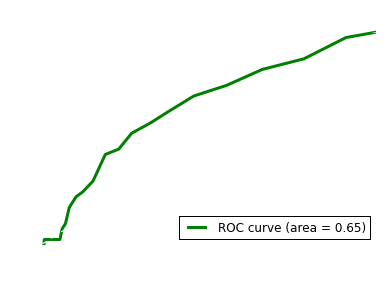

The top 10 most important features:

The daily surprise ratio at 14 o'clock
The daily trust ratio at 2 o'clock
The daily joy ratio at 16 o'clock
The daily joy ratio at 12 o'clock
The daily disgust ratio at 14 o'clock
The daily anger ratio at 16 o'clock
The daily surprise ratio at 2 o'clock
The daily sadness ratio at 14 o'clock
The daily sadness ratio at 15 o'clock
The daily anger ratio at 10 o'clock


In [11]:
BPDUsersData = getUsersData("BPD_fixed_emotion")
regularUsersData = getUsersData("regularUser_en_fixed_emotion")
featuresList = featureExtraction([regularUsersData, BPDUsersData], text_extraction=False)
forest = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)

classifer = plot_ROC(forest, featuresList)
try:
    featureScores = np.argsort(classifer.feature_importances_)[::-1]
except:
    featureScores = np.argsort(np.fabs(classifer.coef_[0]))[::-1]
showImportantFeatures(featureScores, None)


401 Normal and 14 BPD in Training Data
45 Normal and 2 BPD in Test Data
Number of features: 200


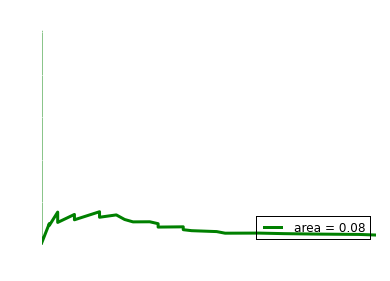

In [12]:

classifer = plot_precision_recall(forest, featuresList)
try:
    featureScores = np.argsort(classifer.feature_importances_)[::-1]
except:
    featureScores = np.argsort(np.fabs(classifer.coef_[0]))[::-1]
#showImportantFeatures(featureScores, None)


In [13]:
BPDUsersData_text = getUsersData("BPD_fixed_emotion",time=False)
regularUsersData_text = getUsersData("regularUser_en_fixed_emotion",time=False)
featuresList, text_model = featureExtraction([regularUsersData_text, BPDUsersData_text], emotion_extraction=False)
X_train, X_test, Y_train, Y_test = trainTestGenerator(featuresList, randomState =90)


740 Normal and 28 BPD in Training Data
83 Normal and 3 BPD in Test Data
Number of features: 4532517


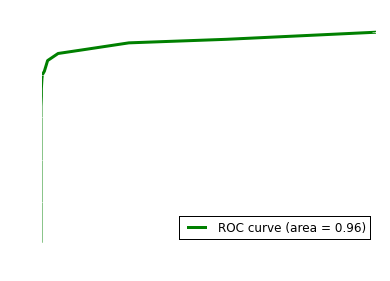

The following are the top 50 most important features:

borderline personality
candidlykristen
bpd_orchid
bpdchat bpdffs
allyc375
bpd bpd
depression http
cassjustcass
valeriewalsh19
officialbpdchat
bpdffs really
abandonment issues
peer support
organiclemon
therapists
lifeinabind
bpd people
bpd_confessions
like bpd
cons
lizard_lala
party
people bpd
til monday
willing learn
way bpd
control bpdchat
day bpdchat
emotions
44lhpqqlf8
visit hospital
mindfulness
pms
number priority
getting worked
love little
grrr
triggered
morning slhxox
bpd dbt
watching meeeee
bpdchat actually
delivery morning
hope sleep
wait til
self defeating
thing want
mh issues
humanity acceptance
desiring ending


In [14]:
#classifer = plot_ROC(RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128), featuresList)
classifer = plot_ROC(forest, featuresList)

try:
    featureScores = np.argsort(classifer.feature_importances_)[::-1]
except:
    featureScores = np.argsort(np.fabs(classifer.coef_[0]))#[::-1]
    
showImportantFeatures(featureScores, text_model, n_features=50)

740 Normal and 28 BPD in Training Data
83 Normal and 3 BPD in Test Data
Number of features: 4532517


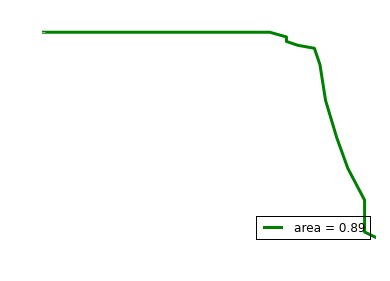

In [15]:

#classifer = plot_precision_recall(RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128), X_train, X_test, Y_train, Y_test)

classifer = plot_precision_recall(forest,featuresList)

try:
    featureScores = np.argsort(classifer.feature_importances_)[::-1]
except:
    featureScores = np.argsort(np.fabs(classifer.coef_[0]))#[::-1]
    
#showImportantFeatures(featureScores, text_model, n_features=50)
    

In [16]:
regularUsersData_text = getUsersData("regularUser_en_fixed_emotion", time=False)
BPDUsersData_text =getUsersData("BPD_581",time=False)
featuresList, text_model = featureExtraction([regularUsersData_text, BPDUsersData_text], emotion_extraction=False)
X_train, X_test, Y_train, Y_test = trainTestGenerator(featuresList, randomState =90)

In [17]:
featuresList[0][0]

<823x5894967 sparse matrix of type '<class 'numpy.float64'>'
	with 7253697 stored elements in Compressed Sparse Row format>

741 Normal and 446 BPD in Training Data
82 Normal and 50 BPD in Test Data
Number of features: 5894967


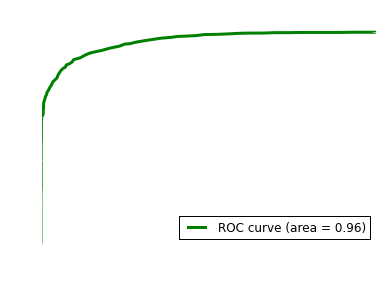

The following are the top 50 most important features:

bpdchat
helps
disorder
borderline personality
bpd
therapy
mentalillness
diagnosis
diagnosed
illness
mental illness
borderline
therapist
season
help
triggers
carldunnjr
personality
suicide
pills
stigma
feeling
thoughts
struggling
emotions
bpd http
suffering
trigger
healingfrombpd
mentalhealth
http
dbt
watch
hospital
personality disorder
school
bipolar
blog
awareness
psychiatrist
anxious
health
birthday
support
angry
happy birthday
boys
play
selfharm
10


In [18]:
forest = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
classifer = plot_ROC(forest, featuresList)

try:
    featureScores = np.argsort(classifer.feature_importances_)[::-1]
except:
    featureScores = np.argsort(np.fabs(classifer.coef_[0]))#[::-1]
    
showImportantFeatures(featureScores, text_model, n_features=50)

741 Normal and 446 BPD in Training Data
82 Normal and 50 BPD in Test Data
Number of features: 5894967


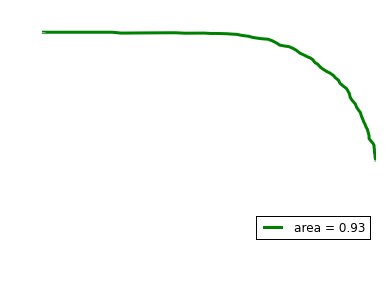

In [19]:
forest = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
classifer = plot_precision_recall(forest,featuresList)

try:
    featureScores = np.argsort(classifer.feature_importances_)[::-1]
except:
    featureScores = np.argsort(np.fabs(classifer.coef_[0]))#[::-1]

In [20]:
# new functions

def getNegativeCount(timeSeries):
    return np.sum(timeSeries["polarity"].values == -1)


def getUsersPolarities(collectionName):
    collection = MongoClient("localhost", 27017)['idea'][collectionName]
    usersPolarties = {}
    for tweet in collection.find():
        userID = tweet["user"]["id"]
        #Processing emotions from Carlos' API
        emotion =  tweet["emotion"]["groups"][0]["name"]
        if len(tweet["emotion"]["groups"]) > 1:
            emotion_2 = tweet["emotion"]["groups"][1]["name"]
            
        ambiguous = True if tweet['emotion']['ambiguous'] == 'yes' else False
       
        if len(tweet["emotion"]["groups"]) > 1:
            emotion_2 = tweet["emotion"]["groups"][1]["name"]    
        else:
            emotion_2 = None
        if tweet["polarity"] == "positive":
            polarity = 1
        elif tweet["polarity"] == "negative":
            polarity = -1
        else:
            polarity = 0
   
            
        date = tweet["created_at"]
        text = tweet['text']

        if userID not in usersPolarties:
            usersPolarties[userID] = {}
        if date not in usersPolarties[userID]:
            usersPolarties[userID][date] = {}
        usersPolarties[userID][date]['text'] = text
        usersPolarties[userID][date]['polarity'] =  polarity
        usersPolarties[userID][date]['emotion'] =  emotion
        usersPolarties[userID][date]['emotion_2'] =  emotion_2
        usersPolarties[userID][date]['ambiguous'] =  ambiguous
    return usersPolarties


def timeSeriesTransform(usersEmotions):
    for userID in usersEmotions:
        usersEmotions[userID] = pd.DataFrame.from_dict(usersEmotions[userID], orient='index').fillna(0)
        usersEmotions[userID]['dt'] = np.zeros(usersEmotions[userID].shape[0],dtype=float)
        usersEmotions[userID].loc[:-1,'dt'] = (usersEmotions[userID].index[1:].values - usersEmotions[userID].index[:-1].values).astype('timedelta64[s]') / np.timedelta64(60, 's')
    return list(usersEmotions.values())



def userVerify(timeSeries, threshold = 0.5, lowerbound = 50):
    http_rows = getHTTPRows(timeSeries)
    average_http_count = np.sum(http_rows) / timeSeries.shape[0]
    duration = np.max(timeSeries.index.values) -  np.min(timeSeries.index.values)
    duration = duration.astype('timedelta64[s]') / np.timedelta64(604800, 's')
    return (average_http_count < threshold) and (timeSeries.shape[0] > lowerbound) and duration > 1


def groupFilter(group):
    new_group = []
    for timeSeries in group:
        if userVerify(timeSeries):
            new_group.append(cleanPost(timeSeries))
    return new_group




def comboTracker(timeSeries, attribute= "polarity"):
    array = timeSeries[attribute]
    starter = array[0]
    combo = 1
    result = []
    for cursor in array[1:]:
        if starter == cursor:
            combo += 1
        else:
            if combo > 1:
                result.append((starter, combo))
            starter = cursor
            combo = 1
    if combo > 1:
         result.append((starter, combo))
    return result

def getHTTPRows(timeSeries):
    count = 0
    patterns = ['http://','https://']
    conditions = timeSeries['text'].str.contains(patterns[0])
    for pattern in patterns[1:]:
        conditions = conditions | timeSeries['text'].str.contains(pattern)

    return conditions.values


def cleanPost(timeSeries):
    left_text = timeSeries['text'].values[:-1]
    right_text = timeSeries['text'].values[1:]
    conditions = np.ones(timeSeries.shape[0],dtype=bool)
    edit_distance = np.vectorize(distance)
    conditions[:-1] =  conditions[:-1] & (edit_distance(left_text, right_text) > 5)
    patterns = ['http://','https://']
    
    for pattern in patterns:
        conditions = conditions & np.logical_not(timeSeries['text'].str.contains(pattern).values)
    timeSeries = timeSeries[conditions]
    timeSeries.loc[:,'dt'] = np.zeros(timeSeries.shape[0],dtype=float)
    timeSeries.loc[:-1,'dt'] = (timeSeries.index[1:].values - timeSeries.index[:-1].values).astype('timedelta64[s]') / np.timedelta64(60, 's')

    return timeSeries


def getFlipsDuration(timeSeries, flips):
    timeSeries = timeSeries[flips]
    timeSeries.loc[:,'dt'] = np.zeros(timeSeries.shape[0],dtype=float)
    timeSeries.loc[:-1,'dt'] = (timeSeries.index[1:].values - timeSeries.index[:-1].values).astype('timedelta64[s]') / np.timedelta64(60, 's')
    return timeSeries['dt'][:-1].values



def getFlips(timeSeries, attribute= 'polarity'):
    flips = np.zeros(timeSeries.shape[0],dtype=bool)
    polarity = timeSeries[attribute].values[:-1]
    right_elements = timeSeries[attribute].values[1:]
    flips[:-1] = (polarity * right_elements) < 0
    return flips

def seriesContains(timeSeries,method ="first"):
    if method == "first":
        match_function = np.vectorize(firstPronuonDetect)
    elif method == "second":
        match_function = np.vectorize(secondPronuonDetect)
    elif method == "third":
            match_function = np.vectorize(thirdPronuonDetect)


    return match_function(timeSeries["text"].str.lower().str.split().values)
    

def firstPronuonDetect(words, matchers=["i","we","i'd","i'm"]):
    for matcher in matchers:
        if matcher in words:
            return True
    return False


def getFirstPronounCount(timeSeries):
    return np.sum(seriesContains(timeSeries))

def comboTracker(timeSeries, attribute= "polarity"):
    array = timeSeries[attribute]
    starter = array[0]
    combo = 1
    result = []
    for cursor in array[1:]:
        if starter == cursor:
            combo += 1
        else:
            if combo > 1:
                result.append((starter, combo))
            starter = cursor
            combo = 1
    if combo > 1:
         result.append((starter, combo))
    return result




def getCombosCount(timeSeries, matcher = -1, lowerbound = 2):
    combos = comboTracker(timeSeries)
    combos_count = sum([hit for element, hit in combos if element == matcher and hit > lowerbound])
    return combos_count
    


def getFlips(timeSeries, attribute= 'polarity'):
    flips = np.zeros(timeSeries.shape[0],dtype=bool)
    polarity = timeSeries[attribute].values[:-1]
    right_elements = timeSeries[attribute].values[1:]
    flips[:-1] = (polarity * right_elements) < 0
    return flips

def getFlipsCount(timeSeries, upperbound=30, lowerbound = 0):
    flips = getFlips(timeSeries)
    durations = getFlipsDuration(timeSeries, flips)
    return np.sum((durations > lowerbound) & (durations < upperbound) )



def getFlipsDuration(timeSeries, flips):
    timeSeries = timeSeries[flips]
    timeSeries.loc[:,'dt'] = np.zeros(timeSeries.shape[0],dtype=float)
    timeSeries.loc[:-1,'dt'] = (timeSeries.index[1:].values - timeSeries.index[:-1].values).astype('timedelta64[s]') / np.timedelta64(60, 's')
    return timeSeries['dt'][:-1].values


def getTextFeature(usersDataList, text_model):
    if text_model == "tfidf":
        model = TfidfVectorizer(stop_words="english",ngram_range = (1,2))
        to_train = True
    else:
        model = text_model
        to_train = False
        
    getText = lambda data : "\n".join(data["text"].values)
    usersTextsList = []
    totalTexts = []
    for usersData in usersDataList:
        usersTexts = []
        for data in usersData:
            text = getText(data)
            totalTexts.append(text)
            usersTexts.append(text)
        usersTextsList.append(usersTexts)
    
    if to_train:
        model.fit(totalTexts)
    
    featuresList = []
    for usersTexts in usersTextsList:
        featuresList.append(model.transform(usersTexts))
        
    return featuresList, model

        

    
def getPolarityFeature(groups):
    features = []
    for group in groups:
        feature = np.zeros((len(group),4),dtype=float)
        for i, timeSeries in enumerate(group):
            tweets_length = timeSeries.shape[0]
            flips_ratio = getFlipsCount(timeSeries) / tweets_length
            combos_ratio = getCombosCount(timeSeries) / tweets_length
            first_pronoun_ratio = getFirstPronounCount(timeSeries) / tweets_length
            negative_ratio = getNegativeCount(timeSeries) / tweets_length
            feature[i][0] = flips_ratio 
            feature[i][1] = combos_ratio
            feature[i][2] = negative_ratio
            feature[i][3] = first_pronoun_ratio
        features.append(feature)
    return features



def getEmotionFeature(groups):
    features = []
    for group in groups:
        feature = np.zeros((len(group),4+8),dtype=float)
        for i, timeSeries in enumerate(group):
            tweets_length = timeSeries.shape[0]
            flips_ratio = getFlipsCount(timeSeries) / tweets_length
            combos_ratio = getCombosCount(timeSeries) / tweets_length
            first_pronoun_ratio = getFirstPronounCount(timeSeries) / tweets_length
            negative_ratio = getNegativeCount(timeSeries) / tweets_length
            feature[i][0] = flips_ratio 
            feature[i][1] = combos_ratio
            feature[i][2] = negative_ratio
            feature[i][3] = first_pronoun_ratio
            #emotions come in
            
            feature[i][4:] = getEmotionRatio(timeSeries)
            
            
            
        features.append(feature)
    return features


def getEmotionRatio(timeSeries):
    emotions = ['surprise', 'fear', 'sadness', 'disgust', 'trust', 'anticipation', 'anger','joy']
    emotion_ratios = []
    conditions = np.logical_not(timeSeries["ambiguous"].values)
    timeSeries = timeSeries[conditions]

    for emotion in emotions:
        total = np.sum((timeSeries["emotion"].values == emotion))
        emotion_ratio = total / timeSeries.shape[0]
        emotion_ratios.append(emotion_ratio)
        
    return emotion_ratios
        





def getJHFeature(groups):
    features = []
    for group in groups:
        feature = np.zeros((len(group),6),dtype=float)
        for i, timeSeries in enumerate(group):
         
            tweets_rate = tweetRate(timeSeries)
            mentio_rate = mentioRate(timeSeries)
            unique_mentions = uniqueMentions(timeSeries)
            frequent_mentions = frequentMentions(timeSeries)
            negative_ratio = getNegativeRatio(timeSeries)
            positive_ratio = getPositiveRatio(timeSeries)
            
            feature[i][0] = tweets_rate 
            feature[i][1] = mentio_rate
            feature[i][2] = unique_mentions
            feature[i][3] = frequent_mentions 
            feature[i][4] = negative_ratio
            feature[i][5] = positive_ratio
          
        features.append(feature)
    return features

def getCombinedFeature(groups):
    features = []
    for group in groups:
        feature = np.zeros((len(group),9+8),dtype=float)
        for i, timeSeries in enumerate(group):
            tweets_length = timeSeries.shape[0]
            tweets_rate = tweetRate(timeSeries)
            mentio_rate = mentioRate(timeSeries)
            unique_mentions = uniqueMentions(timeSeries)
            frequent_mentions = frequentMentions(timeSeries)
            negative_ratio = getNegativeRatio(timeSeries)
            positive_ratio = getPositiveRatio(timeSeries)
            flips_ratio = getFlipsCount(timeSeries) / tweets_length
            combos_ratio = getCombosCount(timeSeries) / tweets_length
            first_pronoun_ratio = getFirstPronounCount(timeSeries) / tweets_length
            
            feature[i][0] = tweets_rate 
            feature[i][1] = mentio_rate
            feature[i][2] = unique_mentions
            feature[i][3] = frequent_mentions 
            feature[i][4] = positive_ratio
            feature[i][5] = negative_ratio
            feature[i][6] = flips_ratio
            feature[i][7] = combos_ratio
            feature[i][8] = first_pronoun_ratio
            feature[i][9:] = getEmotionRatio(timeSeries)
        features.append(feature)
    return features


def featureExtraction(usersDataList, polarity_extraction=True, text_extraction=True, text_model="tfidf"):
    featuresList = []
 

    if polarity_extraction:
        polarity_features = getPolarityFeature(usersDataList)
        
        if not text_extraction:
            featuresList = polarity_features
        
        
    if text_extraction:
        
        text_features, model = getTextFeature(usersDataList, text_model)
        
        
        if polarity_extraction:
            featuresList = featureCombination(polarity_features, text_features)
        else:
            featuresList = text_features
        
    Ylist = []
    for label, usersData in enumerate(usersDataList):
        Y = np.zeros(len(usersData),dtype=int)
        Y[:] = label
        Ylist.append(Y)
        
    if text_extraction:
        return list(zip(featuresList, Ylist)), model 
    else:
        return list(zip(featuresList, Ylist)) 

def emotionExtraction(groups):

 

    featuresList = getEmotionFeature(groups)
        
  
        
    Ylist = []
    for label, usersData in enumerate(groups):
        Y = np.zeros(len(usersData),dtype=int)
        Y[:] = label
        Ylist.append(Y)
        
  
    return list(zip(featuresList, Ylist)) 
    
    
    
def JHfeatureExtraction(groups):

 

    featuresList = getJHFeature(groups)
        
  
        
    Ylist = []
    for label, usersData in enumerate(groups):
        Y = np.zeros(len(usersData),dtype=int)
        Y[:] = label
        Ylist.append(Y)
        
  
    return list(zip(featuresList, Ylist)) 

    
def CombinedfeatureExtraction(groups):

 

    featuresList =getCombinedFeature(groups)
        
  
        
    Ylist = []
    for label, usersData in enumerate(groups):
        Y = np.zeros(len(usersData),dtype=int)
        Y[:] = label
        Ylist.append(Y)
        
  
    return list(zip(featuresList, Ylist)) 

In [21]:
BPD_polarities = getUsersPolarities("BPD_581_emotion")
BPD_timeSeries = groupFilter(timeSeriesTransform(BPD_polarities))
regular_polarities = getUsersPolarities("regularUser_en_fixed_emotion")
regular_timeSeries = groupFilter(timeSeriesTransform(regular_polarities))
groups = [regular_timeSeries, BPD_timeSeries]

/usr/local/lib/python3.4/dist-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [22]:

coach_polarities = getUsersPolarities("coach_tweets_emotion")
coach_timeSeries = groupFilter(timeSeriesTransform(coach_polarities))

In [23]:
len(coach_timeSeries)

12

In [24]:
coach_feature  = getCombinedFeature([coach_timeSeries])[0]


In [25]:
featuresList = CombinedfeatureExtraction(groups)
X, Y = XYGenerator(featuresList)



In [26]:
forest = RandomForestClassifier(n_jobs=-1, n_estimators=1024, max_features="sqrt")
forest.fit(X,Y)
print("Combined Prediction Result:")
print(forest.predict(coach_feature))
print("\n") 
X_GB = X[:,[5,6,7,8,9,10,11,12,13,14,15,16]]
coach_feature_GB = coach_feature[:,[5,6,7,8,9,10,11,12,13,14,15,16]]
forest.fit(X_GB,Y)
print("GB_carlos Prediction Result:")
print(forest.predict(coach_feature_GB))
print("\n")

X_JH = X[:,[0,1,2,3,4,5]]
coach_feature_JH = coach_feature[:,[0,1,2,3,4,5]]
forest.fit(X_JH,Y)
print("John Hopkins Prediction Result:")
print(forest.predict(coach_feature_JH))
print("\n")


Combined Prediction Result:
[0 0 0 1 0 0 0 0 0 0 0 1]


GB_carlos Prediction Result:
[0 0 0 1 0 0 0 0 0 0 0 1]


John Hopkins Prediction Result:
[0 0 0 0 0 0 0 0 0 0 0 0]




526 Normal and 275 BPD in Training Data
59 Normal and 31 BPD in Test Data
Number of features: 3867910


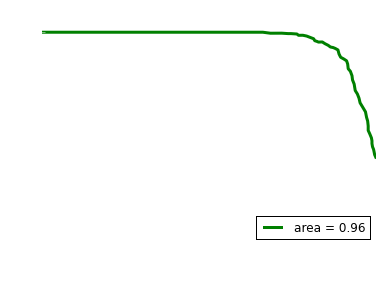

In [28]:

featuresList, text_model = featureExtraction(groups)
forest = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
classifer = plot_precision_recall(forest, featuresList)

526 Normal and 275 BPD in Training Data
59 Normal and 31 BPD in Test Data
Number of features: 3867906


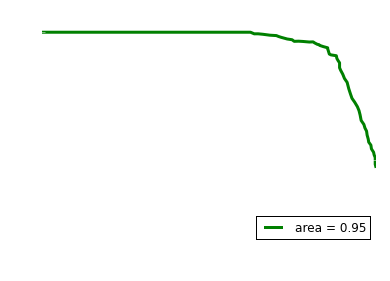

The following are the top 50 most important features:

mental health
bpd
depression
bpdffs
carldunnjr
meds
stigma
mental
pain
suffer
suicide
mh
favorite
bpdchat
health problems
feeling really
mindcharity
tablets
issues
ashamed
feeling
hugs
depressed
therapist
feel better
urge
paranoia
health
helping
feel
personality disorder
scared
season
feels like
hard
xx
wish
sorry
personality
bae
bpdfriends
lonely
physical
know anymore
mentalillness
depression anxiety
dbt skills
miss
sports
therapy


In [29]:
featuresList, text_model = featureExtraction(groups, polarity_extraction=False)
forest = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
classifer = plot_precision_recall(forest, featuresList)
try:
    featureScores = np.argsort(classifer.feature_importances_)[::-1]
except:
    featureScores = np.argsort(np.fabs(classifer.coef_[0]))#[::-1]
    
showImportantFeatures(featureScores, text_model, n_features=50)


526 Normal and 275 BPD in Training Data
59 Normal and 31 BPD in Test Data
Number of features: 4


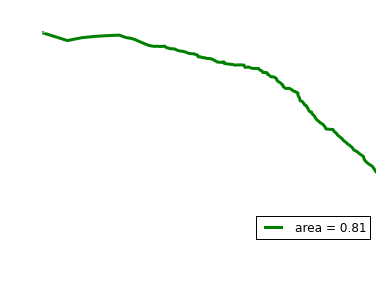

array([ 0.33206509,  0.27055688,  0.23847958,  0.15889846])

In [30]:
featuresList = featureExtraction(groups, text_extraction=False)
classifer = plot_precision_recall(forest, featuresList)
classifer.feature_importances_

In [31]:
classifer.feature_importances_#1 flip 2.combo 3.negative ratio 4.first pronoun ratio

array([ 0.33206509,  0.27055688,  0.23847958,  0.15889846])

526 Normal and 275 BPD in Training Data
59 Normal and 31 BPD in Test Data
Number of features: 6


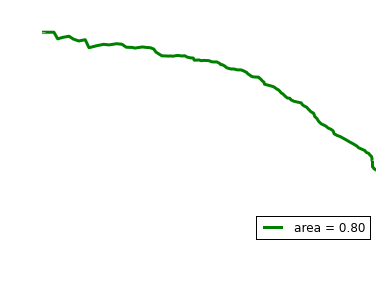

array([ 0.1098351 ,  0.12499039,  0.11310051,  0.1019794 ,  0.38578336,
        0.16431124])

In [32]:
JH_featuresList = JHfeatureExtraction(groups)
classifer = plot_precision_recall(forest, JH_featuresList)
classifer.feature_importances_

526 Normal and 275 BPD in Training Data
59 Normal and 31 BPD in Test Data
Number of features: 17


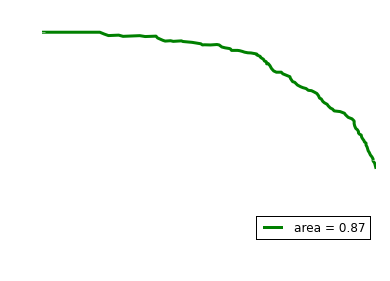

array([ 0.03074886,  0.03336821,  0.02700558,  0.03482407,  0.04008306,
        0.11939822,  0.18056569,  0.14825912,  0.04229743,  0.02582065,
        0.0326127 ,  0.02794145,  0.04730788,  0.04921503,  0.07572419,
        0.03435566,  0.05047219])

In [33]:
com_featuresList = CombinedfeatureExtraction(groups)
classifer = plot_precision_recall(forest, com_featuresList)
classifer.feature_importances_

In [34]:
def plot_multiple_precision_recall(classifier, featuresLists,names,colors=['r','g','b',"y"] , n_fold=20):
    
    

    fig, ax = plt.subplots()
    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white') 
    ax.spines['right'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.title.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.xaxis.label.set_color('white')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    
    for g,featuresList in enumerate(featuresLists):

        SCORES = np.array([])
        LABELS = np.array([])

        X, Y = XYGenerator(featuresList)




        sss = StratifiedShuffleSplit(Y, n_fold, random_state=randint(0,65536) )


        for train_index, test_index in sss:

            X_train, X_test = X[train_index], X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]

            classifier.fit(X_train, Y_train)
            score = classifier.predict_proba(X_test)[:,1]
            SCORES = np.concatenate((SCORES, score))
            LABELS = np.concatenate((LABELS, Y_test))


        precision, recall, _ = precision_recall_curve(LABELS, SCORES, pos_label=1)
        average_precision = average_precision_score(LABELS, SCORES)






        BPD_train = np.count_nonzero(Y_train)
        BPD_test = np.count_nonzero(Y_test)
        normal_train = Y_train.shape[0] - BPD_train
        normal_test = Y_test.shape[0] - BPD_test

       

        plt.plot(recall, precision, label=names[g] , color=colors[g],linewidth=3)
      
        plt.legend(loc="lower right")
        
    print("{} Normal and {} BPD in Training Data".format(normal_train,BPD_train))
    print("{} Normal and {} BPD in Test Data".format(normal_test,BPD_test))

    plt.show()


In [35]:
names = ["GB","GB_Carlos","JH","JH+GB_Carlos"]
new_feature_lists = [featureExtraction(groups, text_extraction=False),emotionExtraction(groups), JHfeatureExtraction(groups),CombinedfeatureExtraction(groups)]

526 Normal and 275 BPD in Training Data
59 Normal and 31 BPD in Test Data


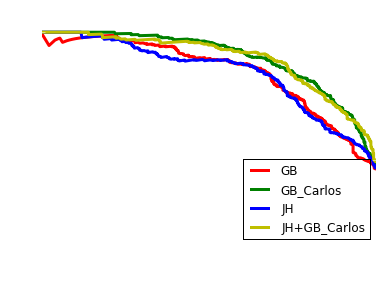

In [36]:
plot_multiple_precision_recall(RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=1024),new_feature_lists,names)

In [37]:

coach_polarities = getUsersPolarities("coach_tweets_emotion")
coach_timeSeries = groupFilter(timeSeriesTransform(coach_polarities))


526 Normal and 275 BPD in Training Data
59 Normal and 31 BPD in Test Data
Number of features: 3867906


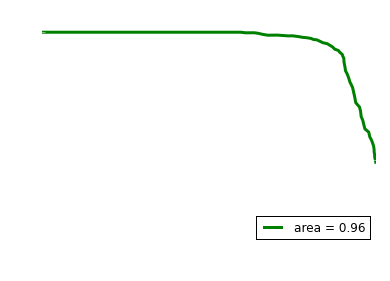

The following are the top 50 most important features:

mental
disorder
illness
meds
dbt
therapy
helps
health
depression
bpd
feel
trigger
bipolar
game
mentalillness
blog
psych
cope
gp
mental health
symptoms
difficult
suffering
self care
medication
diagnosed
healingfrombpd
hospital
coping
carldunnjr
crisis
dbt skills
bath
guilty
moods
triggering
discharged
angry
away
pills
bpd just
shoes
depressed
mh
strong
wondering
accept
dose
thankfully
health issues


In [38]:
featuresList, text_model = featureExtraction(groups, polarity_extraction=False)
forest = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
classifer = plot_precision_recall(forest, featuresList)
try:
    featureScores = np.argsort(classifer.feature_importances_)[::-1]
except:
    featureScores = np.argsort(np.fabs(classifer.coef_[0]))#[::-1]
    
showImportantFeatures(featureScores, text_model, n_features=50)



In [39]:
coach_feature, _ = getTextFeature([coach_timeSeries], text_model)
coach_X = coach_feature[0]
print(classifer.score(coach_X, np.zeros(coach_X.shape[0],dtype=int)))
classifer.predict(coach_X)

0.0833333333333


array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [40]:
pd.set_option('display.max_colwidth', 10000)

In [41]:
patient_x = coach_timeSeries[1]
positive_emotions = ["joy","trust"]
negative_emotions = ["sadness","anger","disgust","fear"]
carlos_polarity = np.zeros(patient_x.shape[0], dtype=int)
for i, emotion in enumerate(patient_x["emotion"].values):
    ambiguity = patient_x["ambiguous"][i]
    if not ambiguity:
        if emotion in positive_emotions:
            carlos_polarity[i] = 1
        elif emotion in negative_emotions:
            carlos_polarity[i] = -1
            
            
patient_x.loc[:,"carlos_polarity"] = carlos_polarity
patient_x.loc[:,"conflict"] = (carlos_polarity * patient_x["polarity"].values) == -1
print("{} Conflicts in {} Post".format(patient_x["conflict"].sum(), patient_x.shape[0]))
patient_x[["text","conflict","polarity","carlos_polarity","emotion"]]


130 Conflicts in 2499 Post


/usr/local/lib/python3.4/dist-packages/pandas/core/indexing.py:249: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


,text,conflict,polarity,carlos_polarity,emotion
2013-03-31 09:08:45,@IamCarrieeeeee @theboatrace you wish ;-) c'mon Oxford #darkbluepride #boatrace #whichblueRU,False,0,0,anticipation
2013-03-31 09:13:50,@IamCarrieeeeee @theboatrace I'm not unfollowing as I want to be able to watch your sad tweets when #Oxford leave the tabs waaaay behind.,False,0,-1,disgust
2013-03-31 14:50:10,@IamCarrieeeeee *sticks tongue out in a mature expression of rivalry* #darkbluepride,False,0,1,joy
2013-03-31 14:58:28,"@clissa89 @IamCarrieeeeee hehe, ""laziness"" I suspect Freud would have other ideas #darkbluepride",True,1,-1,sadness
2013-03-31 15:03:43,"@IamCarrieeeeee I remember you went back to it last year, any more plans? I rowed at ox (though not for ox!)",False,-1,-1,sadness
2013-03-31 15:05:18,"@IamCarrieeeeee @clissa89 lol, I was just aiming for a subconscious support of the superior team #darkbluepride",False,1,0,joy
2013-03-31 15:06:51,@IamCarrieeeeee :-( sad to hear that.,False,-1,-1,sadness
2013-03-31 15:14:36,@IamCarrieeeeee @clissa89 *giggles*,False,0,0,anger
2013-03-31 15:27:23,"Waiting for the annual anti-oxford/cam comments on my fb timeline. They will appear, from usually unprejudiced friends. :-(",False,0,-1,sadness
2013-03-31 15:33:14,@IamCarrieeeeee it really frustrates me,False,0,-1,sadness


In [42]:
patient_x[patient_x["conflict"].values]

,text,emotion_2,polarity,ambiguous,emotion,dt,carlos_polarity,conflict
2013-03-31 14:58:28,"@clissa89 @IamCarrieeeeee hehe, ""laziness"" I suspect Freud would have other ideas #darkbluepride",anger,1,False,sadness,5.250000,-1,True
2013-03-31 20:47:26,"@munchknmunch wow, congratulations! Sounds like you've been on a real journey, you definitely have lots to contribute to the #otalk",disgust,1,False,fear,1117.116667,-1,True
2013-04-06 07:40:57,"@IamCarrieeeeee And you. I may just stop off in the pub, eat chips and drink pepsi max and let him carry on. #tiredlegs",disgust,1,False,anger,31.116667,-1,True
2013-04-06 08:50:23,"@juliakaysen Ooh, cool! I look forward to a report later!",anticipation,1,False,disgust,378.333333,-1,True
2013-04-10 22:29:46,@IamCarrieeeeee @clissa89 @BPDFFS I dunno. A pd2ot goes out for the evening and comes back to a timeline full of slanderous tweets... Harsh.,trust,-1,False,joy,0.950000,1,True
2013-04-20 10:45:13,@thus_spake_z bbbbut those are all inside jobs! :-( #teamduvet @BPDFFS @IamCarrieeeeee @clissa89,0,1,False,sadness,1261.950000,-1,True
2013-04-21 08:01:01,@Girl_Interrupt_ I'm a bit shocked by them tbh #teamduvet @clissa89 @IamCarrieeeeee,anticipation,1,False,sadness,7.466667,-1,True
2013-04-21 09:07:25,"@claireOT @Girl_Interrupt_ @clissa89 @BPDFFS @IamCarrieeeeee nom, I like jaffa cakes. But not tea :-(",anger,1,False,sadness,1.466667,-1,True
2013-04-21 09:17:00,"@BPDFFS @clissa89 @Girl_Interrupt_ @claireOT @IamCarrieeeeee @YorkshireTea Sue's right :-) Now, in a dragon's den stylee: I'm out #teamduvet",sadness,1,False,disgust,433.716667,-1,True
2013-04-23 05:40:02,"@IamCarrieeeeee Moi? I'm a bit exhausted, just 3 days left of placement so you'll see more of me. How're you? @clissa89",anger,1,False,sadness,13.950000,-1,True


In [43]:
sum(getEmotionRatio(patient_x))

1.0

In [44]:
getEmotionFeature(groups)

[array([[ 0.00300601,  0.01903808,  0.18787575, ...,  0.12654321,
          0.15555556,  0.12160494],
        [ 0.        ,  0.        ,  0.08403361, ...,  0.08247423,
          0.04123711,  0.42268041],
        [ 0.00208044,  0.00554785,  0.1220527 , ...,  0.17168142,
          0.11327434,  0.19823009],
        ..., 
        [ 0.00158479,  0.022187  ,  0.12678288, ...,  0.13450292,
          0.07602339,  0.2417154 ],
        [ 0.00980392,  0.00588235,  0.15294118, ...,  0.18055556,
          0.05787037,  0.26851852],
        [ 0.01317614,  0.00970874,  0.15880721, ...,  0.08955224,
          0.07901668,  0.1167691 ]]),
 array([[ 0.        ,  0.13043478,  0.36231884, ...,  0.15517241,
          0.0862069 ,  0.0862069 ],
        [ 0.01983003,  0.07932011,  0.32294618, ...,  0.09046053,
          0.14144737,  0.11513158],
        [ 0.03571429,  0.10714286,  0.38095238, ...,  0.07936508,
          0.04761905,  0.22222222],
        ..., 
        [ 0.01945895,  0.05125771,  0.21404841, ...,

526 Normal and 275 BPD in Training Data
59 Normal and 31 BPD in Test Data


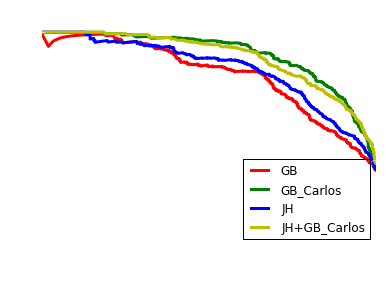

In [48]:
plot_multiple_precision_recall(RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=1024),new_feature_lists,names)

In [47]:
3 +4 

7